<a href="https://colab.research.google.com/github/nem-42098/SL_Proj_Unlearning/blob/main/Unlearn_test_FM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone --branch code-refactor https://github.com/nem-42098/SL_Proj_Unlearning.git
# import os
# os.chdir('/content/SL_Proj_Unlearning')

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

### Load Pre-Trained VGG network
> #### https://github.com/chenyaofo
> ### Note: There is some issue with using Batch Norm before ReLu as it creates a bias in the network. So people exchange the order between the two for tackling the bias

In [3]:
### First time when you wan to download the model
device=torch.device('cuda')
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
model
# model=model.to(device)
### For future uses:Loading from the local

# model_1=torch.hub.load("C:/Users/nmura/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master",'hubconf.py',source='local')



Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Check which pre-trained model are available:

In [4]:
torch.hub.list("chenyaofo/pytorch-cifar-models", force_reload=True)

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to C:\Users\nmura/.cache\torch\hub\master.zip


['cifar100_mobilenetv2_x0_5',
 'cifar100_mobilenetv2_x0_75',
 'cifar100_mobilenetv2_x1_0',
 'cifar100_mobilenetv2_x1_4',
 'cifar100_repvgg_a0',
 'cifar100_repvgg_a1',
 'cifar100_repvgg_a2',
 'cifar100_resnet20',
 'cifar100_resnet32',
 'cifar100_resnet44',
 'cifar100_resnet56',
 'cifar100_shufflenetv2_x0_5',
 'cifar100_shufflenetv2_x1_0',
 'cifar100_shufflenetv2_x1_5',
 'cifar100_shufflenetv2_x2_0',
 'cifar100_vgg11_bn',
 'cifar100_vgg13_bn',
 'cifar100_vgg16_bn',
 'cifar100_vgg19_bn',
 'cifar100_vit_b16',
 'cifar100_vit_b32',
 'cifar100_vit_h14',
 'cifar100_vit_l16',
 'cifar100_vit_l32',
 'cifar10_mobilenetv2_x0_5',
 'cifar10_mobilenetv2_x0_75',
 'cifar10_mobilenetv2_x1_0',
 'cifar10_mobilenetv2_x1_4',
 'cifar10_repvgg_a0',
 'cifar10_repvgg_a1',
 'cifar10_repvgg_a2',
 'cifar10_resnet20',
 'cifar10_resnet32',
 'cifar10_resnet44',
 'cifar10_resnet56',
 'cifar10_shufflenetv2_x0_5',
 'cifar10_shufflenetv2_x1_0',
 'cifar10_shufflenetv2_x1_5',
 'cifar10_shufflenetv2_x2_0',
 'cifar10_vgg11_bn

### Downlaoding the Dataset and Creating the Dataloaders

In [5]:
### Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )
])
### Pytorch Datasets
train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)
### Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
len(train_dataset)

50000

### Create the Forget Dataset

In [7]:
# Define the classes
classes = ['forget', 'retain']

# Create a dictionary to store datasets for each class
class_datasets = {class_name: [] for class_name in classes}

# Iterate through the CIFAR-10 dataset and split it into class-specific subsets
for image, label in train_dataset:
  if label == 1:
    class_datasets['forget'].append((image, label))

  else:
      class_datasets['retain'].append((image, label))

# You now have class-specific subsets in the class_datasets dict


#### Forget and Retain

In [8]:
# Class split
retain_dataloader = torch.utils.data.DataLoader(class_datasets['retain'], batch_size=128, shuffle=True, num_workers=2)
forget_dataloader = torch.utils.data.DataLoader(class_datasets['forget'], batch_size=128, shuffle=True, num_workers=2)

# Random split
# train_split_dataset,forget_split_dataset=torch.utils.data.random_split(train_dataset,lengths=[45000,5000])
# retain_dataloader = torch.utils.data.DataLoader(train_split_dataset,  batch_size=128, shuffle=True, num_workers=2)
# forget_dataloader = torch.utils.data.DataLoader(forget_split_dataset, batch_size=128, shuffle=True, num_workers=2)

# Unlearner class


### Using the Lower precision based model. 
> ### There is some problems with this method. Because the counterpart gives better result.

In [39]:
from tools.Unlearner_FM_precision import Unlearner_FM_precision
r_perf=[]

R=list(np.linspace(0.001,0.1,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
for i in R:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM_precision(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model, mask_index,num_of_param=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader)

    forget_perf=Unlearner_FM_precision.test(new_model,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM_precision.test(new_model,retain_dataloader,'cuda')
    test_perf=Unlearner_FM_precision.test(new_model,testloader,'cuda')

    r_perf.append([forget_perf,retain_perf,test_perf])




Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:18643


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:35732


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:52822


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:69912


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:87001


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:104091


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:121180


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:138270


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:155360


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:15536


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:31072


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:46608


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:62144


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:77680


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:93216


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:108752


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:124288


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:139824


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:155360


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:310720


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:621440


Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Parameter Type check when pushed to GPU torch.float16
Finished Computing Hessian Diagonal
Model is on CUDA (GPU)
Parameter Type check torch.float16
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:932160


In [40]:
r_perf

[[0.99, 0.9992444444444445, 0.9174],
 [0.9934, 0.9991111111111111, 0.9178],
 [0.9882, 0.9975777777777778, 0.9115],
 [0.9708, 0.9993111111111111, 0.9138],
 [0.9952, 0.9982888888888889, 0.9144],
 [0.9922, 0.9974222222222222, 0.9111],
 [0.991, 0.9951111111111111, 0.9068],
 [0.9924, 0.9943555555555555, 0.905],
 [0.9806, 0.9931333333333333, 0.9031],
 [0.9854, 0.9922222222222222, 0.9031],
 [0.9954, 0.9993333333333333, 0.9183],
 [0.9812, 0.9956888888888888, 0.9092],
 [0.9872, 0.9987777777777778, 0.9155],
 [0.9956, 0.9985111111111111, 0.9162],
 [0.9908, 0.9981333333333333, 0.9132],
 [0.9782, 0.9747333333333333, 0.8839],
 [0.991, 0.9957777777777778, 0.9076],
 [0.9952, 0.9934888888888889, 0.9071],
 [0.9852, 0.9915333333333334, 0.9011],
 [0.9944, 0.9938444444444444, 0.9056],
 [0.1416, 0.8173333333333334, 0.6768],
 [0.0, 0.1111111111111111, 0.1],
 [0.0, 0.1111111111111111, 0.1]]

In [29]:
r_perf

[[0.1822, 0.565, 0.4987],
 [0.9948, 0.9994666666666666, 0.9186],
 [0.9908, 0.9979333333333333, 0.9122],
 [0.9624, 0.9833111111111111, 0.892],
 [0.9408, 0.9732222222222222, 0.8727],
 [0.6086, 0.8173333333333334, 0.7206]]

### Counterpart: Maintaining the original precision of the model and diverting some operation to CPU.

In [9]:
# from tools.Unlearner_FM import Unlearner_FM
# torch.cuda.empty_cache()
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
# unlearner_1 = Unlearner_FM(0.02,model, lr = 1e-6)


from tools.Unlearner_FM import Unlearner_FM
r_perf_1=[]

R=list(np.linspace(0.001,0.01,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
forget_path='./data/forget_hess_cifar10_vgg11_class1.pt'
retain_path='./data/retain_hess_cifar10_vgg11_class1.pt'
for i in R:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model_1, mask_index_1,num_of_param_1=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader,forget_hess_path=forget_path,retain_hess_path=retain_path)


    forget_perf=Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')
    test_perf=Unlearner_FM.test(new_model_1,testloader,'cuda')

    r_perf_1.append([forget_perf,retain_perf,test_perf])



Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


KeyboardInterrupt: 

In [62]:
R_=[ round(i,3) for i in R ]

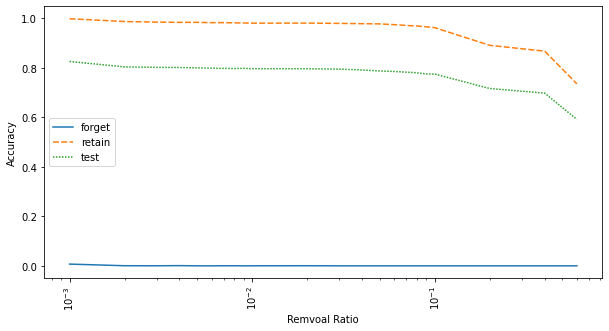

In [69]:
plt.figure(figsize=(10,5))
df =pd.DataFrame(r_perf_1)
df.index=[ i for i in R_]
df.columns=['forget','retain','test']
sns.lineplot(data=df)
plt.xscale('log')
plt.xticks(rotation=90)
plt.xlabel('Remvoal Ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
r_perf_1

[[0.007, 0.9988222222222222, 0.8262],
 [0.0004, 0.9875777777777778, 0.8041],
 [0.0002, 0.9852, 0.8024],
 [0.0008, 0.9841555555555556, 0.8016],
 [0.0, 0.9842666666666666, 0.8005],
 [0.0, 0.9830888888888889, 0.7989],
 [0.0002, 0.9830444444444445, 0.7983],
 [0.0002, 0.9821777777777778, 0.7975],
 [0.0, 0.9818222222222223, 0.7985],
 [0.0002, 0.9808, 0.7968],
 [0.0, 0.9809111111111111, 0.7969],
 [0.0004, 0.9811777777777778, 0.7967],
 [0.0, 0.9799555555555556, 0.7952],
 [0.0, 0.9788444444444444, 0.7918],
 [0.0, 0.9779111111111111, 0.7876],
 [0.0, 0.9748888888888889, 0.7857],
 [0.0, 0.9716, 0.7828],
 [0.0, 0.9694222222222222, 0.7803],
 [0.0, 0.9661555555555555, 0.7755],
 [0.0, 0.9627111111111111, 0.7752],
 [0.0, 0.8913555555555556, 0.7168],
 [0.0, 0.8678, 0.6981],
 [0.0, 0.7358, 0.5921]]

In [9]:
from tools.Unlearner_FM import Unlearner_FM
r_perf_2=[]

R=list(np.linspace(0.001,0.01,10))
R+=list(np.linspace(0.01,0.1,10))
R+=[0.2,0.4,0.6]
forget_path='./data/forget_hess_cifar10_vgg11_class1.pt'
retain_path='./data/retain_hess_cifar10_vgg11_class1.pt'
for i in R:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    torch.cuda.empty_cache()
    unlearner = Unlearner_FM(i,model, lr = 1e-6)
    ### Getting the new model masked model

    new_model_1, mask_index_1,num_of_param_1=unlearner.Fisher_Masking(retain_dataloader,forget_dataloader,forget_hess_path=forget_path,retain_hess_path=retain_path)

    new_model_1,epoch_log=unlearner.fine_tune(new_model_1,retain_dataloader)
    forget_perf=Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')
    retain_perf=Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')
    test_perf=Unlearner_FM.test(new_model_1,testloader,'cuda')

    r_perf_2.append([forget_perf,retain_perf,test_perf,[epoch_log]])
    

Using cache found in C:\Users\nmura/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Total Number of Kernels and Neurons:1553600, Number of masked Paramters:1553


 10%|█         | 1/10 [01:03<09:29, 63.30s/it]


KeyboardInterrupt: 

## Run the unlearning


In [14]:
### Getting the new model masked model

new_model_1, mask_index_1,num_of_param_1=unlearner_1.Fisher_Masking(retain_dataloader,forget_dataloader)

Finished Computing Hessian Diagonal
Finished Computing Hessian Diagonal
Total Number of Kernels and Neurons:1553600, Number of masked Paramters:31072


In [15]:
Unlearner_FM.test(new_model_1,forget_dataloader,'cuda')

0.0

In [16]:
Unlearner_FM.test(new_model_1,retain_dataloader,'cuda')

0.9576666666666667

In [17]:
Unlearner_FM.test(new_model_1,testloader,'cuda')

0.7854

We can see that the unlearning process may need many epochs in the erasure phase to converge. We could also try to increase the learning rate for faster convergence.

In [ ]:
import pandas as pd
import seaborn as sns

log_df = pd.DataFrame.from_records(unlearner.log, columns=['phase', 'epoch', 'batch', 'tp', 'n', 'loss'])
unlearn_history = log_df.groupby(['phase', 'epoch']).agg({'tp':sum, 'n':sum, 'loss': 'mean'}).reset_index()
unlearn_history['accuracy'] = unlearn_history.tp / unlearn_history.n
unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss_scale'] = unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss'] /unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss'].max() 
unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss_scale'] = unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss'] /unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss'].max() 

sns.lineplot(data = unlearn_history, x = 'epoch', y='loss_scale', hue='phase')

## Check model performance
We now try check the model performance on the retain and forget set. 

In [ ]:
models = {'original':model, 'dumb':unlearner.dumb_model, 'erased':unlearner.erased_model, 'retrained':unlearner.retrained_model}
dataloaders = {'retain':retain_dataloader, 'forget':forget_dataloader, 'test':testloader}

performances = []
for model_name, m in models.items():
  for dl_name, dl in dataloaders.items():
    acc = test(m, dl)
    performances.append((model_name, dl_name, acc))

Strangely the dumb network has 0% performance on the forget set, and this may have a negative impact, note that the performance on the forget set is even too low (we expected 10%, not less).

Outside of that we note that this procedure works great for the retain and test which are fitted very nicely, and we can even see that there's a big leap in performance from the erased model to the retrained model.

In [ ]:
perf_df = pd.DataFrame.from_records(performances, columns=['model', 'data_partition', 'accuracy'])

tb = pd.pivot_table(perf_df, index='data_partition', columns='model', values='accuracy')
sns.heatmap(tb, annot = True, fmt='.2%')